In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from functions import *
from scipy.stats import norm
import warnings
import time
warnings.simplefilter("ignore", RuntimeWarning)

In [2]:
def plot_mse_conf(sample_sizes, mse_means,mse_cis,name = 'scenario_1.png'):
    """
    Plot MSE versus sample size with 95% confidence intervals and save the figure.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(sample_sizes, mse_means, marker='o', linestyle='-', color='b', label='Mean MSE')
    plt.fill_between(sample_sizes, 
                    [m - ci for m, ci in zip(mse_means, mse_cis)], 
                    [m + ci for m, ci in zip(mse_means, mse_cis)], 
                    color='b', alpha=0.2, label='95% CI')
    plt.title('MSE vs. Sample Size with Confidence Interval', fontsize=20)
    plt.xlabel('Sample Size', fontsize=18)
    plt.ylabel('Mean Squared Error (MSE)', fontsize=18)
    plt.xscale('log')
    plt.grid(True, which="both", ls="--")
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(name, dpi=300)
    plt.show()

def modified_surface_heatmap_plot(heatmaps, sample_sizes, name = 'heat_0.png'):
    """
    Plot heatmaps of estimands for various sample sizes alongside the ground truth and save the output.
    """
    # Number of plots is now the number of sample sizes
    num_plots = len(sample_sizes)  # Excluding ground truth from the count here
    fig, axs = plt.subplots(1, num_plots + 1, figsize=(10 * (num_plots + 1), 6))  # +1 for ground truth

    # Define font sizes
    title_fontsize = 20
    label_fontsize = 18
    arg1_range = np.linspace(-1.5, 1.5, 20)
    arg2_range = np.linspace(-1.5, 1.5, 20)
    ARG1, ARG2 = np.meshgrid(arg1_range, arg2_range)
    
    # Extract ground truth heatmap data
    Z_f0_original, _ = heatmaps[0]  # Assuming the first heatmap tuple contains the ground truth
    vmin_val = min(Z_f0_original.min(), min(Z_f.min() for _, Z_f in heatmaps))
    vmax_val = max(Z_f0_original.max(), max(Z_f.max() for _, Z_f in heatmaps))

    # Plot each estimand
    for i, (_, Z_f) in enumerate(heatmaps):
        c = axs[i].imshow(Z_f, extent=[ARG1.min(), ARG1.max(), ARG2.min(), ARG2.max()], origin='lower', aspect='auto', cmap='viridis', interpolation='bicubic', vmin=vmin_val, vmax=vmax_val)
        fig.colorbar(c, ax=axs[i])
        axs[i].set_title(f'n={sample_sizes[i]}', fontsize=title_fontsize)
        axs[i].set_xlabel(r'$X^T \beta$', fontsize=label_fontsize)
        if i == 0:
            axs[i].set_ylabel(r'$X^T \xi - \tau$', fontsize=label_fontsize)
    
    # Plot Ground Truth last on the right-most side
    c0 = axs[-1].imshow(Z_f0_original, extent=[ARG1.min(), ARG1.max(), ARG2.min(), ARG2.max()], origin='lower', aspect='auto', cmap='viridis', interpolation='bicubic', vmin=vmin_val, vmax=vmax_val)
    fig.colorbar(c0, ax=axs[-1])
    axs[-1].set_title('Ground Truth', fontsize=title_fontsize)
    axs[-1].set_xlabel(r'$X^T \beta$', fontsize=label_fontsize)
    axs[-1].set_ylabel('', fontsize=label_fontsize)  # No label needed here as it's identical to others

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(name, dpi=300)
    plt.show()

def calculate_mse_heatmaps(ground_truth, estimations):
    """
    Compute mean squared errors between the ground truth and each estimated heatmap.
    """
    mse_values = []
    for estimation in estimations:
        mse = np.mean((ground_truth - estimation) ** 2)
        mse_values.append(mse)
    return mse_values



In [3]:
import optuna
import numpy as np
from scipy.stats import norm
import time
from sklearn.model_selection import train_test_split


# Revised optuna_objective: use p-1 angles
def optuna_objective(trial, X, Y, T, h, objective_func, lam, K, weights=None):
    p = X.shape[1]
    num_angles = p - 1  # number of angles needed
    # For the first angle, restrict to [0, pi/2] to enforce a positive first coordinate.
    angle0 = trial.suggest_uniform("angle_0", 0, np.pi/2)
    angles = [angle0]
    # The remaining angles in [0, pi]
    for i in range(1, num_angles):
        angles.append(trial.suggest_uniform(f"angle_{i}", 0, np.pi))
    XI = np.array(spherical_to_cartesian_new(*angles))
    loss = objective_func(XI, X, Y, T, h, lam, K, weights)
    return loss

# Revised optuna_train: reconstruct XI using only p-1 angles.
def optuna_train(X_train, Y_train, T_train, h, objective_func, lam, K=norm.pdf, n_trials=100, weights=None):
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: optuna_objective(trial, X_train, Y_train, T_train, h, objective_func, lam, K, weights),
                   n_trials=n_trials)
    
    best_trial = study.best_trial
    p = X_train.shape[1]
    num_angles = p - 1
    angles_best = [best_trial.params[f"angle_{i}"] for i in range(num_angles)]
    XI_best = spherical_to_cartesian_new(*angles_best)
    
    exi = X_train - high_dim_nw(np.dot(X_train, XI_best) - T_train, X_train, h, K)
    eyi = Y_train - high_dim_nw(np.dot(X_train, XI_best) - T_train, Y_train, h, K)
    beta = exi.T @ eyi / np.sum(exi ** 2, axis=0)
    
    return np.array(XI_best), np.array(beta), study, study.best_value

# Modified calculate_heatmaps_optuna using the new optuna_train.
def calculate_heatmaps_optuna(X, T, Y, beta, xi, n, p, best_h, f0, n_trials=200):
    """
    Splits the data, fits the model using optuna_train, and then computes
    heatmap grids based on the estimated XI and beta.
    """
    # Split data into training and test sets.
    Z = np.concatenate([X, T.reshape(-1, 1), Y.reshape(-1, 1)], axis=1)
    Z_train, _ = train_test_split(Z, test_size=0.1, random_state=42)
    X_train = Z_train[:, :p]
    T_train = Z_train[:, p]
    Y_train = Z_train[:, p + 1]

    # Fit model using optuna_train.
    XI_opt, BETA_opt, study, best_value = optuna_train(X_train, Y_train, T_train, best_h,
                                                       objective_func=objective_lasso, lam=0.0, 
                                                       n_trials=n_trials)
    # Define the ranges for the heatmap.
    arg1_range = np.linspace(-1.5, 1.5, 20)
    arg2_range = np.linspace(-1.5, 1.5, 20)
    ARG1, ARG2 = np.meshgrid(arg1_range, arg2_range)
    ARG1_flat = ARG1.ravel()
    ARG2_flat = ARG2.ravel()
    
    # Define the function using the model.
    def f(arg1, arg2):
        return arg1 + nw(arg2, np.dot(X_train, XI_opt) - T_train, Y_train - np.dot(X_train, BETA_opt), best_h)

    # Generate heatmap data.
    Z_flat_f0 = np.array([f0(a1, a2) for a1, a2 in zip(ARG1_flat, ARG2_flat)])
    Z_f0 = Z_flat_f0.reshape(ARG1.shape)
    
    Z_flat_f = np.array([f(a1, a2) for a1, a2 in zip(ARG1_flat, ARG2_flat)])
    Z_f = Z_flat_f.reshape(ARG1.shape)

    return XI_opt, BETA_opt, Z_f0, Z_f


## Experiments Setup

<h2> Scenario 1

100%|██████████| 100/100 [04:51<00:00,  2.91s/trial, best loss: 0.014291741536900873]


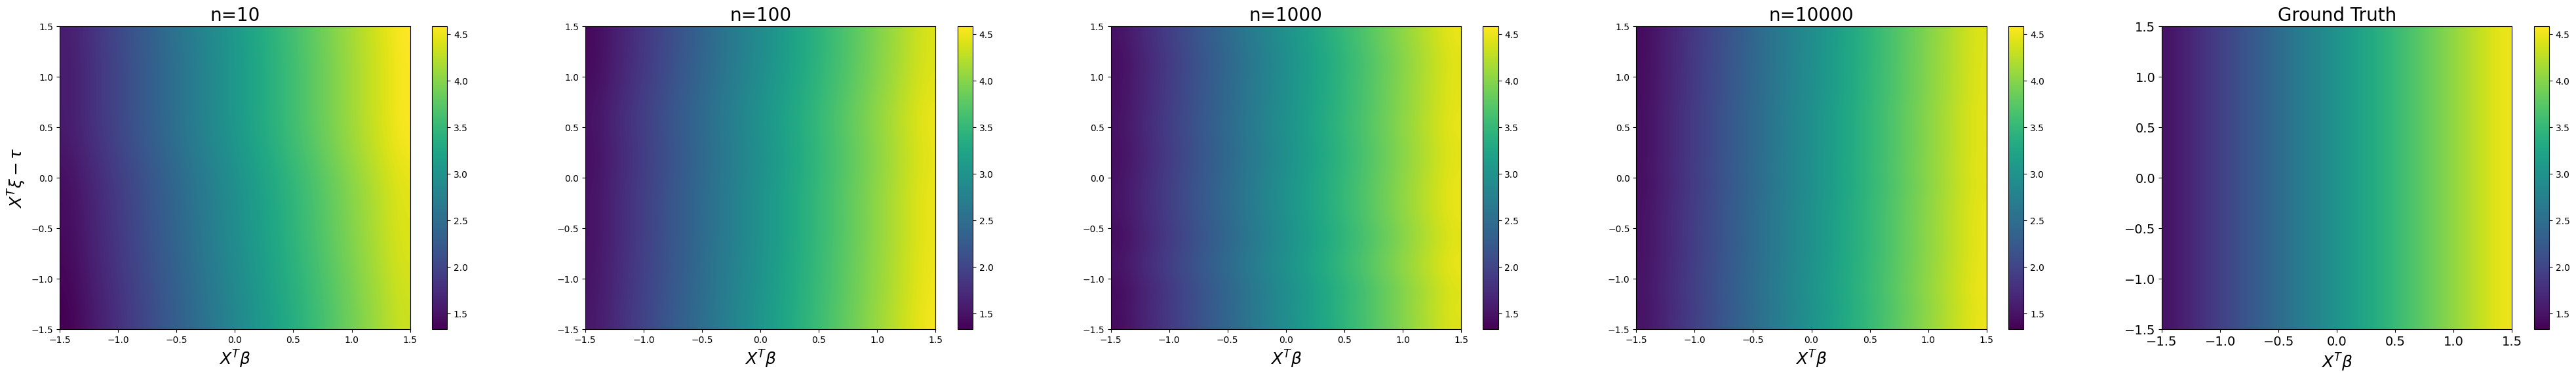

In [5]:
# ### simulation ###
sample_sizes = [10,100,1000,10000]
heatmaps_1 = []
from functions import *

def f1(arg1, arg2):
    def somefunction(x):
        return 3 # model a constant case where treatment does not influence the outcome
    return arg1 + somefunction(arg2)

def generate_data_1(n=2000, seed=42, func=f1, TRUE_beta=None, TRUE_xi=None):
    np.random.seed(seed)
    p = 4
    A = np.random.rand(p, p)
    cov = A @ A.T
    mean = np.random.uniform(-1, 1, p)
    if TRUE_beta is None or TRUE_xi is None:
        beta = np.random.uniform(-1, 1, p)
        xi = np.random.uniform(0, 1, p)
        xi /= np.linalg.norm(xi)
        xi[1:] *= np.random.choice([-1, 1], size=p-1)
    else:
        beta, xi = TRUE_beta, TRUE_xi
    accepted_X, accepted_T, accepted_Y = [], [], []
    count = 0
    while count < n:
        batch = max(n, 1000)
        # X_batch = np.random.randn(batch, p)
        X_batch = np.random.multivariate_normal(mean, cov, batch)
        T_batch = np.random.randn(batch)
        score1 = X_batch @ beta
        score2 = X_batch @ xi - T_batch
        mask = (score1 >= -1.5) & (score1 <= 1.5) & (score2 >= -1.5) & (score2 <= 1.5)
        X_acc = X_batch[mask]
        T_acc = T_batch[mask]
        Y_acc = func(score1, score2)[mask]
        accepted_X.append(X_acc)
        accepted_T.append(T_acc)
        accepted_Y.append(Y_acc)
        count += X_acc.shape[0]
    X_final = np.concatenate(accepted_X)[:n]
    T_final = np.concatenate(accepted_T)[:n]
    Y_final = np.concatenate(accepted_Y)[:n]
    return X_final, T_final, Y_final, beta, xi


seed = 12345
for n in sample_sizes:
    # Generate data, fit model, and calculate Z_f0 and Z_f for each n
    X, T, Y, TRUE_beta, TRUE_xi = generate_data_1(n, seed, f1)
    n,p = X.shape
    best_h = n**(-2/(2+p)) 
    XI_opt, BETA_opt, Z_f0, Z_f = calculate_heatmaps_hyperopt(X, T, Y, TRUE_beta, TRUE_xi, n, p, best_h, f1, max_evals=100)
    # For Differential Evolution:
    # XI_opt, BETA_opt, Z_f0, Z_f = calculate_heatmaps_de(X, T, Y, TRUE_beta, TRUE_xi, n, p, best_h, f1, maxiter=100)
    # Alternatively, for CMA-ES:
    # XI_opt, BETA_opt, Z_f0, Z_f = calculate_heatmaps_cma(X, T, Y, TRUE_beta, TRUE_xi, n, p, best_h, f1, sigma=0.1, maxiter=100)
    # for optuna
    # XI_opt, BETA_opt, Z_f0, Z_f = calculate_heatmaps_optuna(X, T, Y, TRUE_beta, TRUE_xi, n, p, best_h, f1, n_trials=200)
    heatmaps_1.append((Z_f0, Z_f))

modified_surface_heatmap_plot(heatmaps_1, sample_sizes)

100%|██████████| 100/100 [04:47<00:00,  2.88s/trial, best loss: 0.014403320535931616]


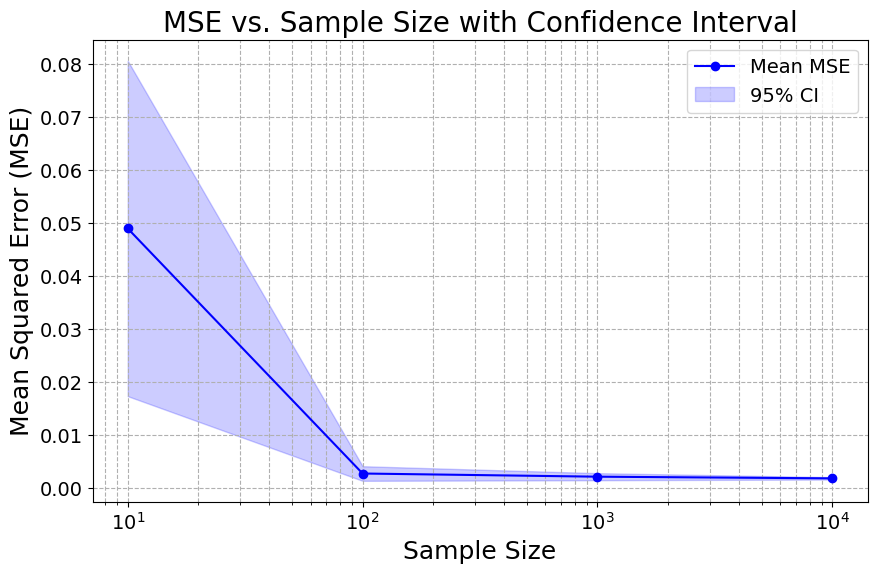

In [6]:
import numpy as np
import matplotlib.pyplot as plt

num_bootstrap_samples = 10  # Number of bootstrap samples to generate
conf_level = 0.95  # Confidence level for confidence intervals
sample_sizes = [10,100,1000,10000]
mse_values_1_means = []  # To store the mean MSEs for each sample size
mse_values_1_cis = []  # To store the confidence intervals for each sample size

for n in sample_sizes:
    X, T, Y, TRUE_beta, TRUE_xi = generate_data_1(n, seed, f1)
    n, p = X.shape
    best_h = n ** (-2 / (2 + p))
    # Z_f0, _ = calculate_heatmaps_hyperopt(X, T, Y, TRUE_beta, TRUE_xi, n, p, best_h, f1, max_evals=200)
    
    mse_values = []  # To store MSE values for bootstrap samples
    for i in range(num_bootstrap_samples):
        # np.random.seed(seed)
        indices = np.random.choice(np.arange(n), size=n, replace=True)
        X_bs, T_bs, Y_bs = X[indices], T[indices], Y[indices]
        _, _, Z_f0, Z_f_bs = calculate_heatmaps_hyperopt(X_bs, T_bs, Y_bs, TRUE_beta, TRUE_xi, n, p, best_h, f1, max_evals=100)
        mse = calculate_mse_heatmaps(Z_f0, [Z_f_bs])[0]
        mse_values.append(mse)
    
    mse_mean = np.mean(mse_values)
    mse_std = np.std(mse_values, ddof=1)
    ci_half_width = mse_std * 1.96 / np.sqrt(num_bootstrap_samples)  # 95% CI for normally distributed data
    mse_values_1_means.append(mse_mean)
    mse_values_1_cis.append(ci_half_width)

# Plotting
plot_mse_conf(sample_sizes, mse_values_1_means,mse_values_1_cis, "scenario_1.png")


<h2> Scenario 2

100%|██████████| 100/100 [04:36<00:00,  2.76s/trial, best loss: 0.002271422518083705]


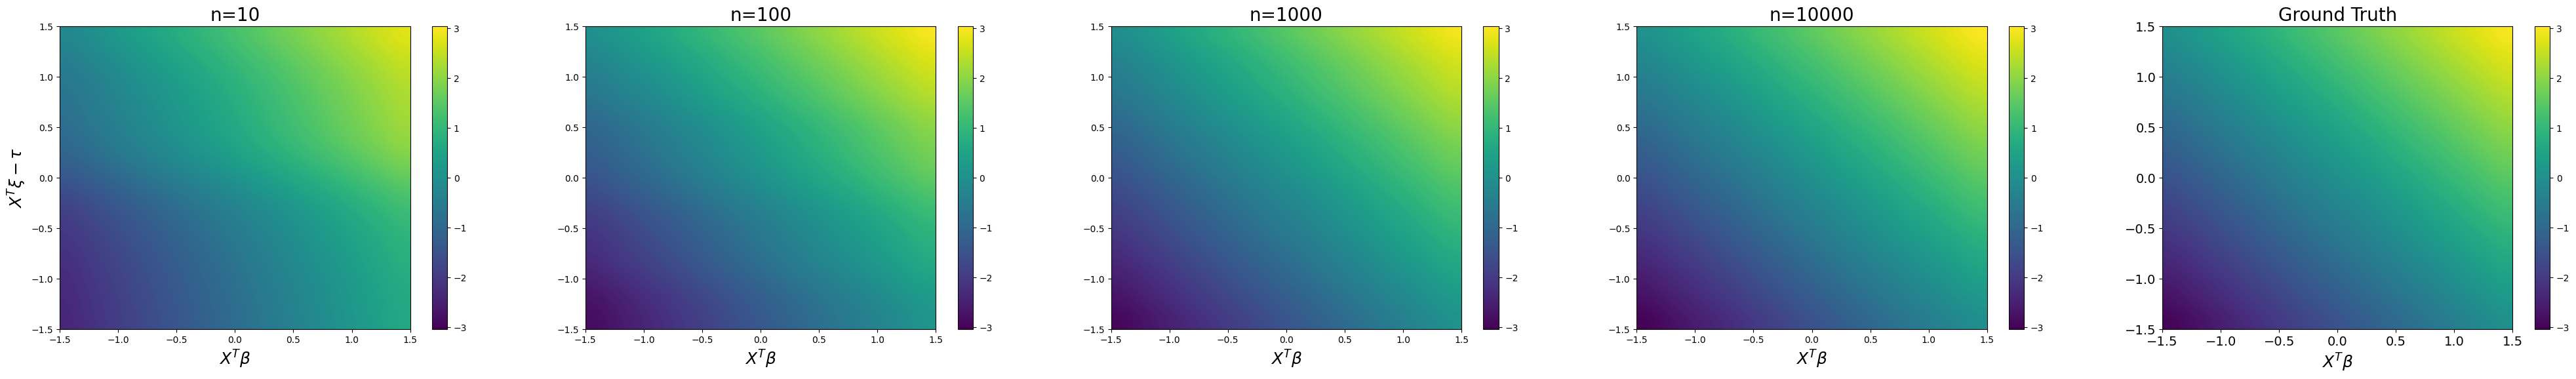

In [7]:
sample_sizes = [10,100,1000, 10000]
heatmaps_2 = []
from functions import *

def f2(arg1, arg2):
    def somefunction(x):
        return x
    return arg1 + somefunction(arg2)


def generate_data_2(n=2000, seed=42, func=f2, TRUE_beta=None, TRUE_xi=None):
    np.random.seed(seed)
    p = 4
    A = np.random.rand(p, p)
    cov = A @ A.T
    mean = np.random.uniform(-1, 1, p)
    if TRUE_beta is None or TRUE_xi is None:
        beta = np.random.uniform(-1, 1, p)
        xi = np.random.uniform(0, 1, p)
        xi /= np.linalg.norm(xi)
        xi[1:] *= np.random.choice([-1, 1], size=p-1)
    else:
        beta, xi = TRUE_beta, TRUE_xi
    X_acc, T_acc, Y_acc = [], [], []
    count = 0
    while count < n:
        batch = max(n, 1000)
        X_batch = np.random.multivariate_normal(mean, cov, batch)
        T_batch = np.random.normal(0, 1, batch)
        score1 = X_batch @ beta
        score2 = X_batch @ xi - T_batch
        mask = (score1 >= -1.5) & (score1 <= 1.5) & (score2 >= -1.5) & (score2 <= 1.5)
        if np.any(mask):
            X_acc.append(X_batch[mask])
            T_acc.append(T_batch[mask])
            Y_batch = func(score1, score2)
            Y_acc.append(Y_batch[mask])
            count += np.sum(mask)
    X_final = np.concatenate(X_acc)[:n]
    T_final = np.concatenate(T_acc)[:n]
    Y_final = np.concatenate(Y_acc)[:n]
    return X_final, T_final, Y_final, beta, xi


    
seed = 12345
for n in sample_sizes:
    X, T, Y, TRUE_beta, TRUE_xi = generate_data_2(n, seed, f2)
    n,p = X.shape
    best_h = n**(-2/(2+p)) 
    _, _, Z_f0, Z_f = calculate_heatmaps_hyperopt(X, T, Y, TRUE_beta, TRUE_xi, n, p, best_h, f2, max_evals=100)
    heatmaps_2.append((Z_f0, Z_f))



modified_surface_heatmap_plot(heatmaps_2, sample_sizes)


100%|██████████| 100/100 [04:47<00:00,  2.87s/trial, best loss: 0.00531849286219705]


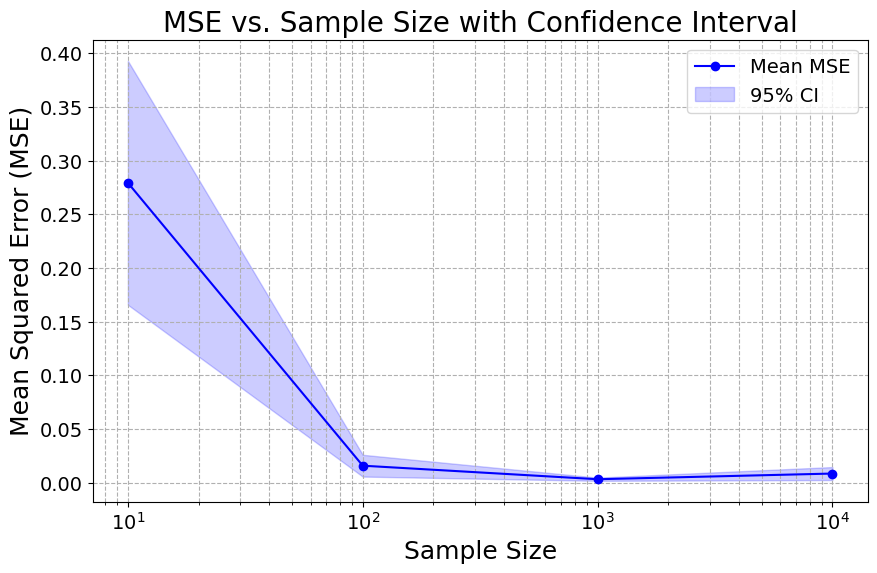

In [8]:
num_runs = 10
sample_sizes = [10,100,1000,10000]
mse_values_2_means = []
mse_values_2_cis = []

for n in sample_sizes:
    seed = 42  # Use a fixed seed
    X, T, Y, TRUE_beta, TRUE_xi = generate_data_2(n, seed, f2)
    n, p = X.shape
    best_h = n ** (-2 / (2 + p))
    mse_runs = []  # Collect MSEs for multiple runs here
    for run in range(num_runs):
        indices = np.random.choice(range(n), size=n, replace=True)
        X_bs, T_bs, Y_bs = X[indices], T[indices], Y[indices]
        _, _, Z_f0, Z_f = calculate_heatmaps_hyperopt(X_bs, T_bs, Y_bs, TRUE_beta, TRUE_xi, n, p, best_h, f2, max_evals=100)
        # Calculate MSE using the ground truth and the bootstrap estimation
        mse = calculate_mse_heatmaps(Z_f0, [Z_f])
        mse_runs.append(mse[0])  # Assuming calculate_mse_heatmaps returns a list

    # Calculate mean and confidence interval for MSEs of current sample size
    mse_mean = np.mean(mse_runs)
    mse_ci = np.std(mse_runs) * 1.96 / np.sqrt(len(mse_runs))  # 95% CI, assuming normal distribution
    mse_values_2_means.append(mse_mean)
    mse_values_2_cis.append(mse_ci)
plot_mse_conf(sample_sizes, mse_values_2_means,mse_values_2_cis,"scenario_2.png")

<h2> Scenario 3

100%|██████████| 100/100 [04:27<00:00,  2.68s/trial, best loss: 0.1635429748423018]


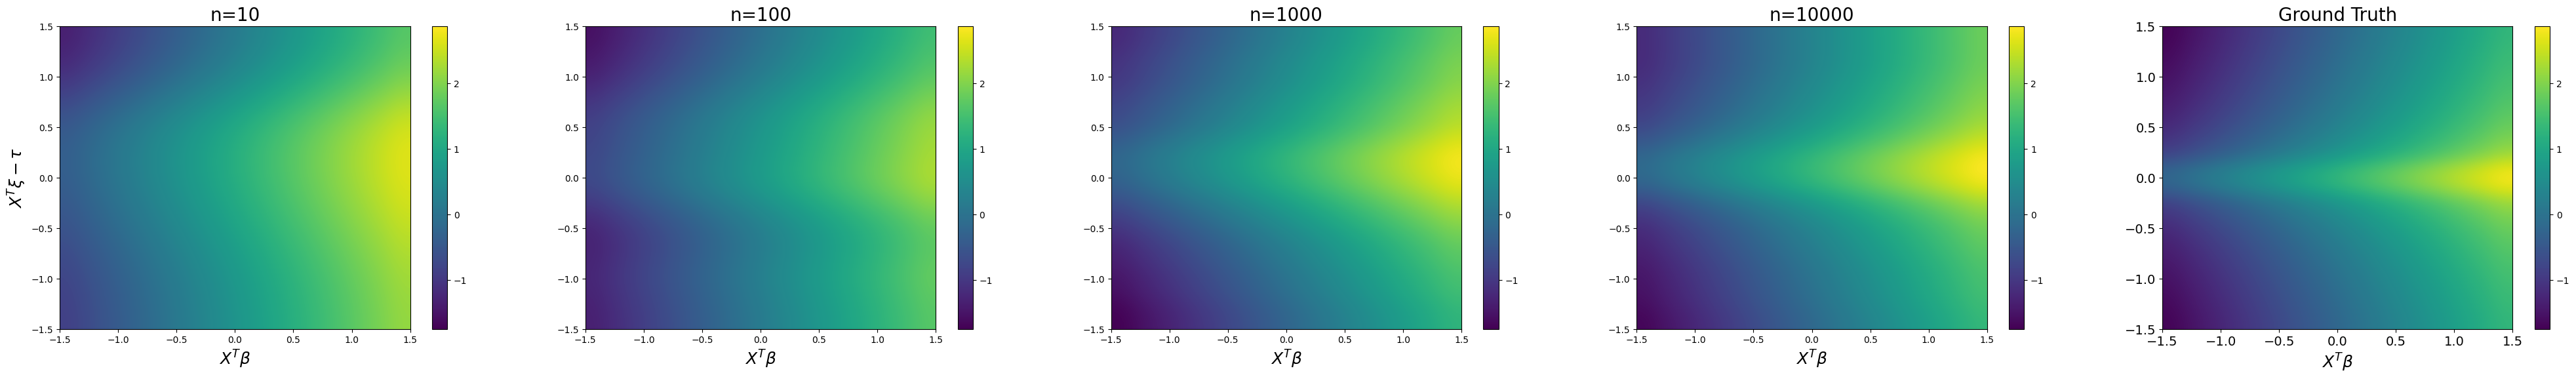

In [9]:
sample_sizes = [10, 100, 1000, 10000]
heatmaps_3 = []
def f3(arg1,arg2):
    return arg1 - 0.5 * np.log(np.abs(arg2))

def generate_data_3(n=2000, seed=42, TRUE_beta=None, TRUE_xi=None):
    np.random.seed(seed)
    p = 4
    if TRUE_beta is None or TRUE_xi is None:
        beta = np.random.uniform(-1, 1, p)
        xi = np.random.uniform(0, 1, p)
        xi /= np.linalg.norm(xi)
        xi[1:] *= np.random.choice([-1, 1], size=p-1)
    else:
        beta, xi = TRUE_beta, TRUE_xi
    X_list, T_list = [], []
    cnt = 0
    while cnt < n:
        m = max(n, 1000)
        X4 = np.random.uniform(-1, 1, m)
        X1 = np.abs(X4)**0.5 + np.random.uniform(-1, 1, m)
        X2 = 0.5 * X1 + np.random.uniform(-0.5, 0.5, m)
        X3 = 0.3 * X1 + 0.3 * X2 + np.random.uniform(-0.4, 0.4, m)
        T_batch = np.sin(X2*X3) + np.random.uniform(-0.6, 0.6, m)
        X_batch = np.vstack((X1, X2, X3, X4)).T
        s1 = X_batch @ beta
        s2 = X_batch @ xi - T_batch
        mask = (s1 >= -1.5) & (s1 <= 1.5) & (s2 >= -1.5) & (s2 <= 1.5)
        if mask.sum():
            X_list.append(X_batch[mask])
            T_list.append(T_batch[mask])
            cnt += mask.sum()
    X_final = np.concatenate(X_list)[:n]
    T_final = np.concatenate(T_list)[:n]
    s1 = X_final @ beta
    s2 = X_final @ xi - T_final
    Y_final = f3(s1, s2)
    return X_final, T_final, Y_final, beta, xi

    
seed = 123
for n in sample_sizes:
    X, T, Y, TRUE_beta, TRUE_xi = generate_data_3(n, seed)
    n,p = X.shape
    best_h = n**(-2/(2+p))
    _, _, Z_f0, Z_f = calculate_heatmaps_hyperopt(X, T, Y, TRUE_beta, TRUE_xi, n, p, best_h, f3, max_evals=100)
    heatmaps_3.append((Z_f0, Z_f))

modified_surface_heatmap_plot(heatmaps_3, sample_sizes)

100%|██████████| 100/100 [04:25<00:00,  2.65s/trial, best loss: 0.17458977340372223]


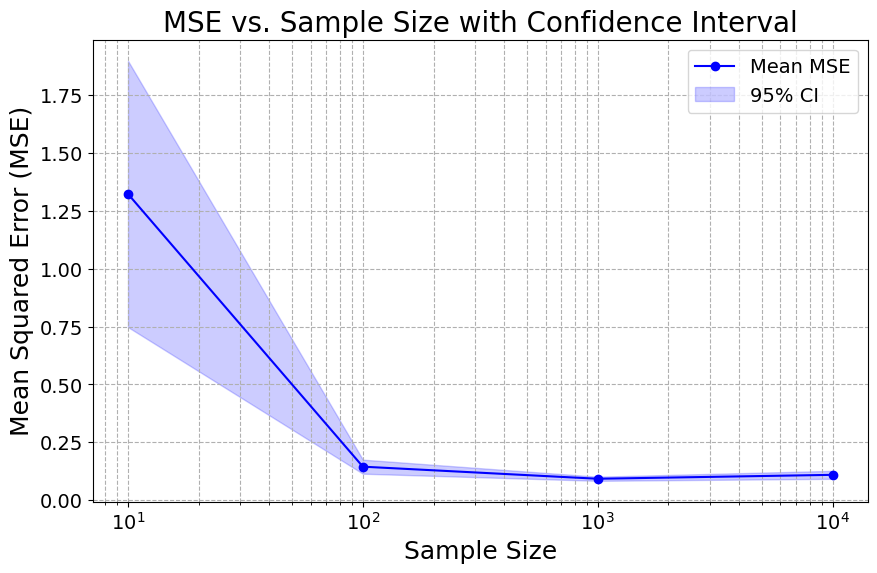

In [10]:
num_runs = 10
mse_values_3_means = []
mse_values_3_cis = []

for n in sample_sizes:
    # Generate data only once per sample size
    X, T, Y, TRUE_beta, TRUE_xi = generate_data_3(n, seed)
    n, p = X.shape
    best_h = n ** (-2 / (2 + p))
    
    mse_runs = []  # Collect MSEs for multiple runs here
    for run in range(num_runs):
        # Bootstrap: Sample with replacement from the original data
        indices = np.random.choice(range(n), size=n, replace=True)
        X_bs, T_bs, Y_bs = X[indices], T[indices], Y[indices]
        
        _,_, Z_f0, Z_f = calculate_heatmaps_hyperopt(X_bs, T_bs, Y_bs, TRUE_beta, TRUE_xi, n, p, best_h, f3, max_evals=100)
        # Calculate MSE using the ground truth and the bootstrap estimation
        mse = calculate_mse_heatmaps(Z_f0, [Z_f])
        mse_runs.append(mse[0])  # Assuming calculate_mse_heatmaps returns a list

    # Calculate mean and confidence interval for MSEs of current sample size
    mse_mean = np.mean(mse_runs)
    mse_ci = np.std(mse_runs) * 1.96 / np.sqrt(len(mse_runs))  # 95% CI, assuming normal distribution
    mse_values_3_means.append(mse_mean)
    mse_values_3_cis.append(mse_ci)

plot_mse_conf(sample_sizes, mse_values_3_means,mse_values_3_cis,"scenario_3.png")

<h2> Scenario 4

100%|██████████| 100/100 [04:38<00:00,  2.78s/trial, best loss: 0.013059430689192606]


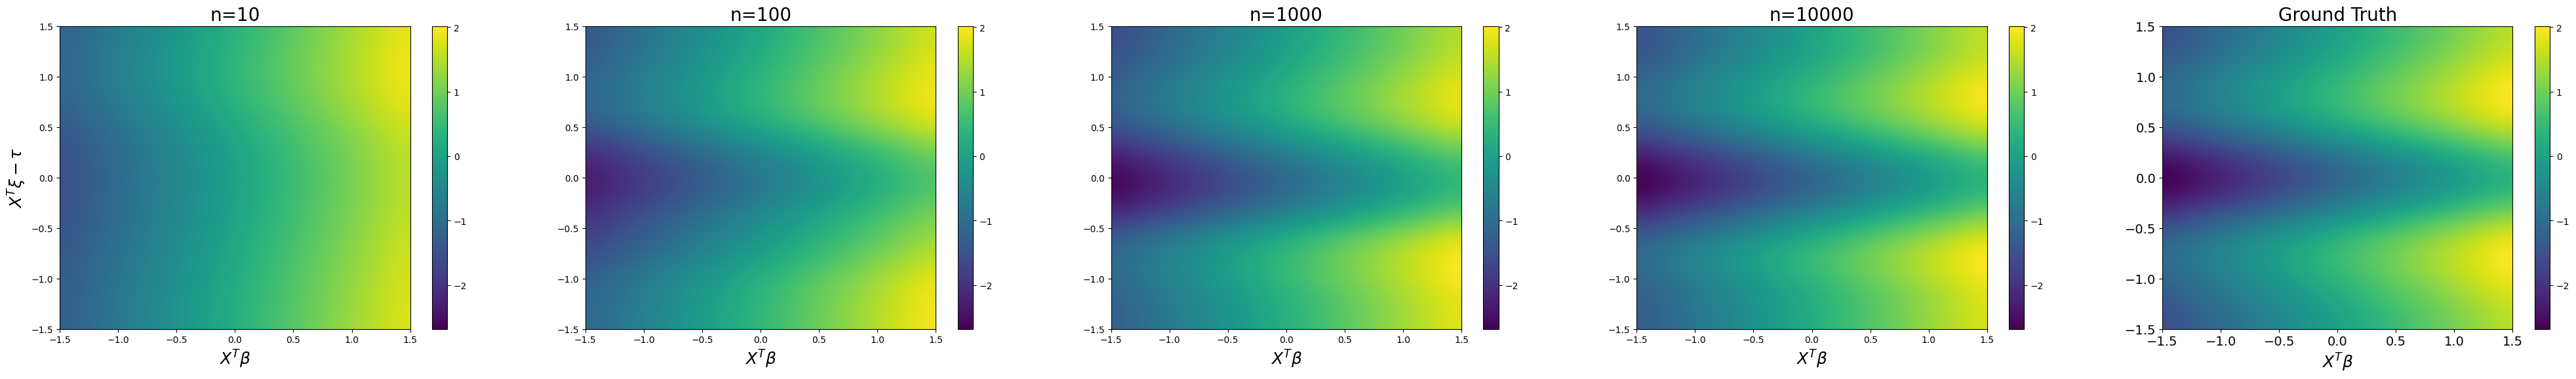

In [11]:

sample_sizes = [10,100,1000,10000]
heatmaps_4 = []

def f4(arg1, arg2):
    # Create a function with two peaks using a trigonometric function
    return arg1 -  1.2 * np.cos(1.0*np.pi * arg2) * np.exp(- (arg2**2))

def generate_binary_variables(n, num_binary):
    X_binary = np.zeros((n, num_binary))
    # Define initial probabilities for the first binary variable
    initial_prob = np.random.uniform(0, 1)
    X_binary[:, 0] = np.random.binomial(1, initial_prob, n)
    
    # Generate remaining binary variables based on previous ones
    for i in range(1, num_binary):
        logit_p = 0.5 * X_binary[:, i-1] - 0.25
        prob = 1 / (1 + np.exp(-logit_p))
        X_binary[:, i] = np.random.binomial(1, prob, n)
    
    return X_binary

def generate_data_4(n=500, p=5, c=0.2, seed=12345):
    np.random.seed(seed)
    num_cont = int(c * p); num_bin = p - num_cont
    cov = np.full((num_cont, num_cont), 0.5); np.fill_diagonal(cov, 1)
    mean = np.zeros(num_cont)
    beta = np.random.uniform(-1, 1, p)
    xi = np.random.uniform(0, 1, p); xi /= np.linalg.norm(xi); xi[1:] *= np.random.choice([-1, 1], p-1)
    X_list, T_list = [], []
    cnt = 0
    while cnt < n:
        m = max(n, 100)
        X_cont = 0.3 * np.random.multivariate_normal(mean, cov, m)
        X_bin = generate_binary_variables(m, num_bin)
        X_batch = np.hstack((X_cont, X_bin))
        T_batch = np.random.uniform(-1, 1, m)
        s1 = X_batch @ beta; s2 = X_batch @ xi - T_batch
        mask = (s1 >= -1.5) & (s1 <= 1.5) & (s2 >= -1.5) & (s2 <= 1.5)
        if mask.sum() > 0:
            X_list.append(X_batch[mask])
            T_list.append(T_batch[mask])
            cnt += mask.sum()
    X_final = np.concatenate(X_list)[:n]
    T_final = np.concatenate(T_list)[:n]
    Y_final = f4(X_final @ beta, X_final @ xi - T_final)
    return X_final, T_final, Y_final, beta, xi

p,c,seed = 4, 0.4, 44
for n in sample_sizes:
    X, T, Y, TRUE_beta, TRUE_xi = generate_data_4(n, p, c, seed)
    n,p = X.shape
    best_h = n**(-2/(2+p)) 
    # print(best_h)
    _, _, Z_f0, Z_f = calculate_heatmaps_hyperopt(X, T, Y, TRUE_beta, TRUE_xi, n, p, best_h, f4, max_evals=100)
    heatmaps_4.append((Z_f0, Z_f))

modified_surface_heatmap_plot(heatmaps_4, sample_sizes)

100%|██████████| 100/100 [04:32<00:00,  2.72s/trial, best loss: 0.010575401523549018]


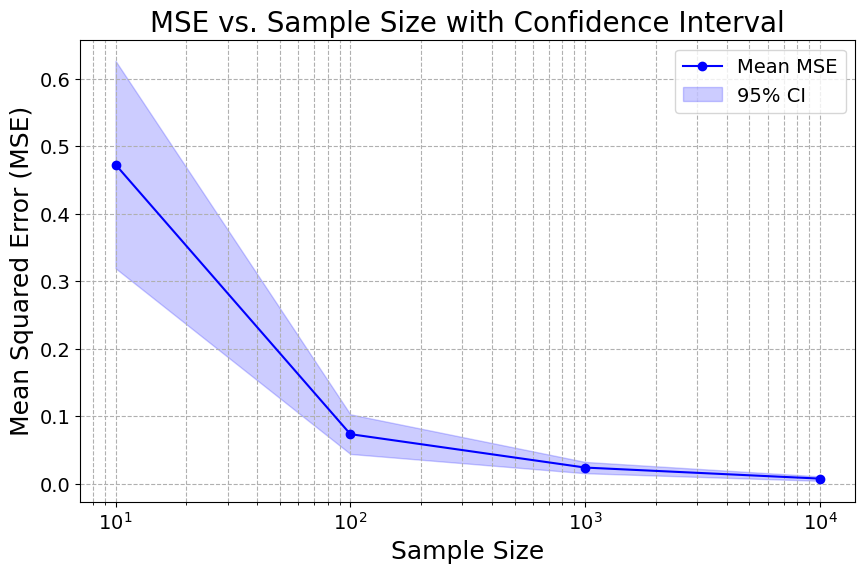

In [12]:
import numpy as np
import matplotlib.pyplot as plt

num_runs = 10
mse_values_4_means = []
mse_values_4_cis = []
for n in sample_sizes:
    X, T, Y, TRUE_beta, TRUE_xi = generate_data_4(n, p, c, seed)
    n, p = X.shape
    best_h = n ** (-2 / (2 + p))
    mse_runs = []  # Collect MSEs for multiple runs here
    for run in range(num_runs):
        indices = np.random.choice(range(n), size=n, replace=True)
        X_bs, T_bs, Y_bs = X[indices], T[indices], Y[indices]
        n_s, p_s = X_bs.shape
        _, _, Z_f0, Z_f = calculate_heatmaps_hyperopt(X_bs, T_bs, Y_bs, TRUE_beta, TRUE_xi, n_s, p_s, best_h, f4, max_evals=100)        
        # Calculate MSE using the ground truth and the bootstrap estimation
        mse = calculate_mse_heatmaps(Z_f0, [Z_f])
        mse_runs.append(mse[0])  # Assuming calculate_mse_heatmaps returns a list

    # Calculate mean and confidence interval for MSEs of current sample size
    mse_mean = np.mean(mse_runs)
    mse_ci = np.std(mse_runs) * 1.96 / np.sqrt(len(mse_runs))  # 95% CI, assuming normal distribution
    mse_values_4_means.append(mse_mean)
    mse_values_4_cis.append(mse_ci)
plot_mse_conf(sample_sizes, mse_values_4_means,mse_values_4_cis,"scenario_4.png")


<h2> Combine overall plot

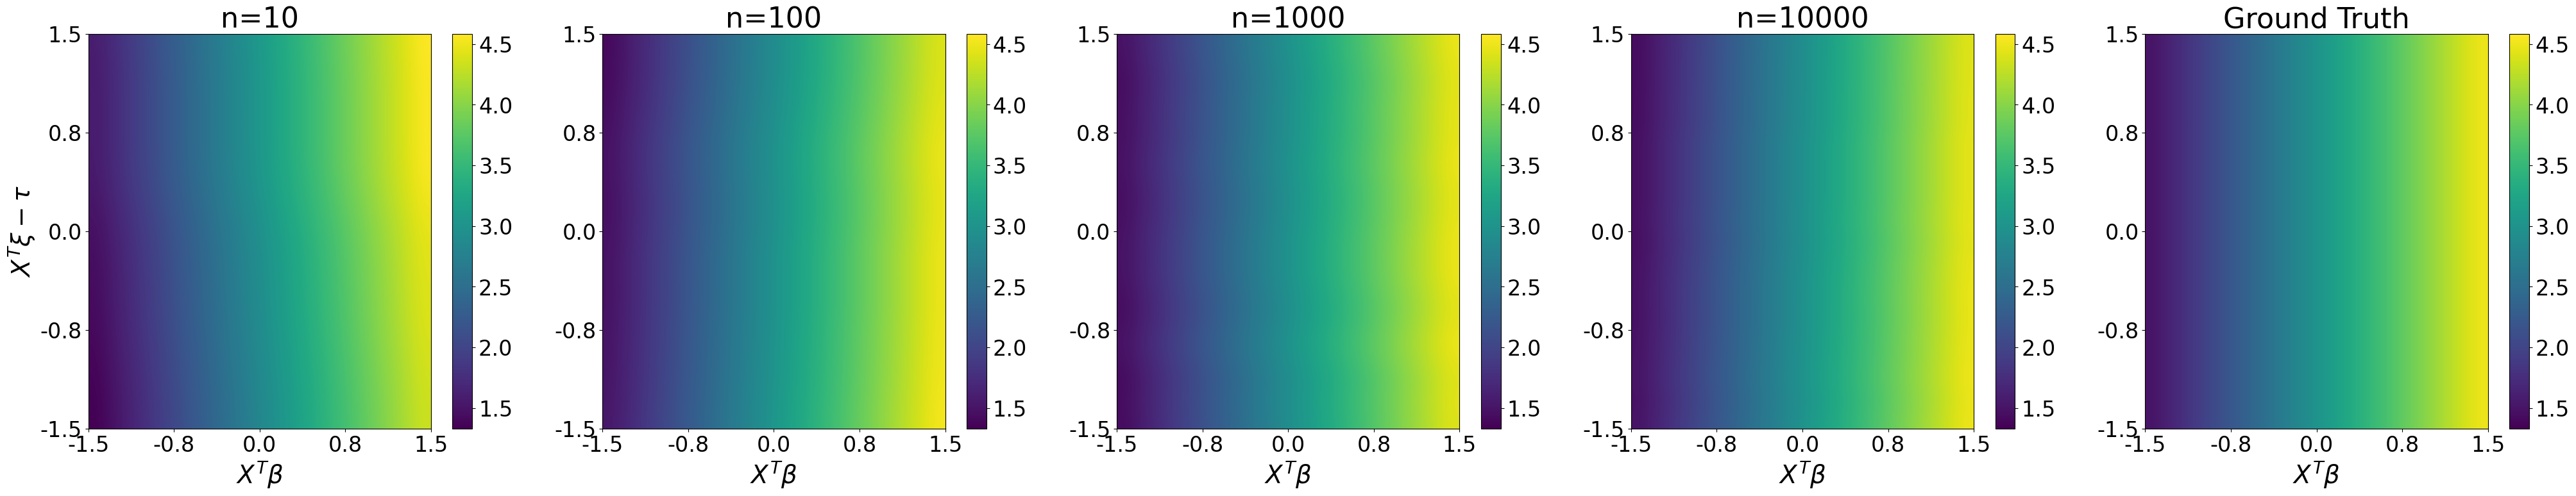

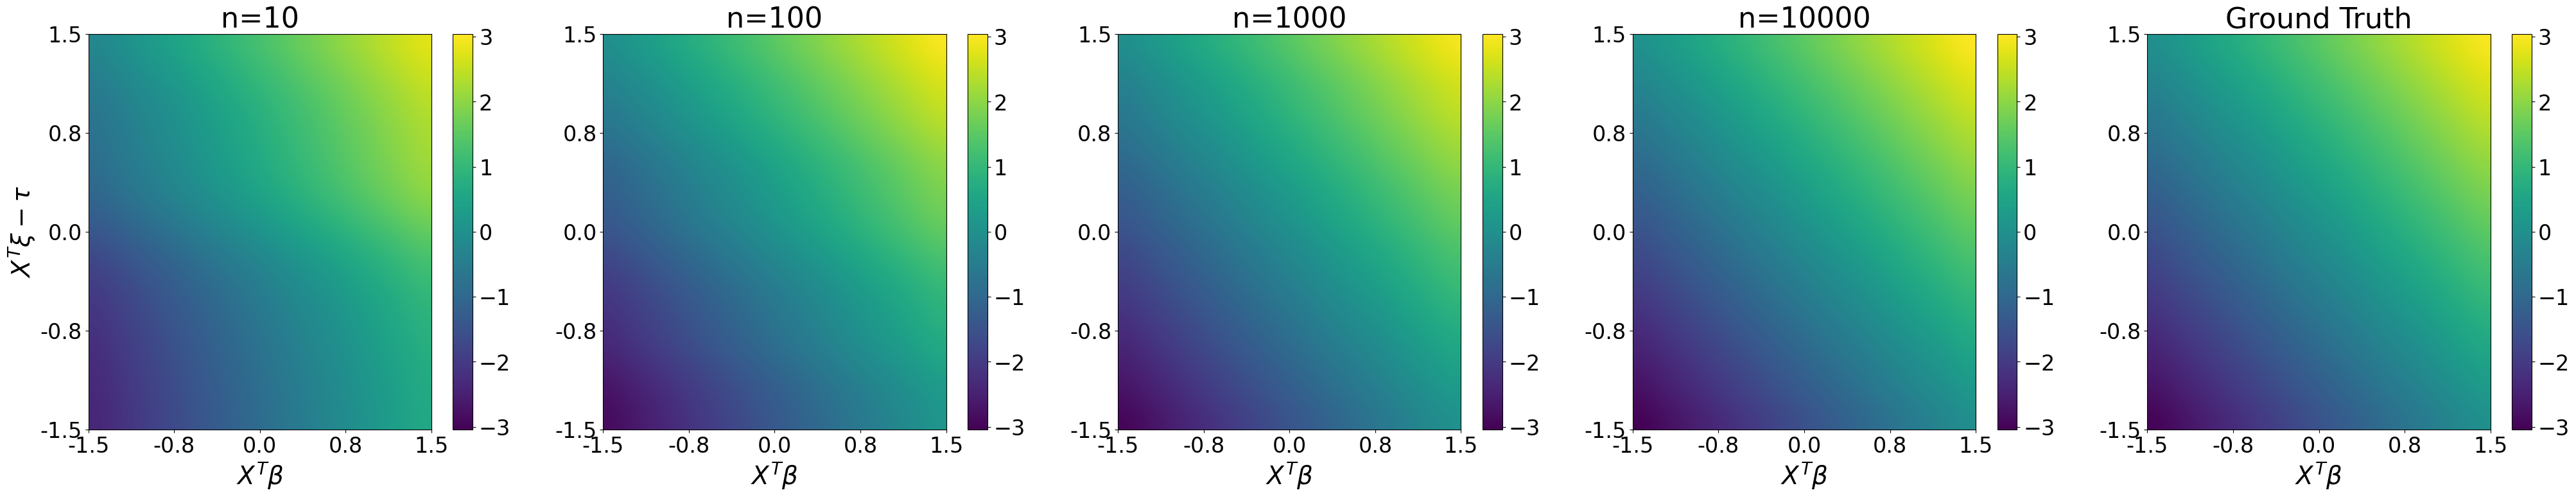

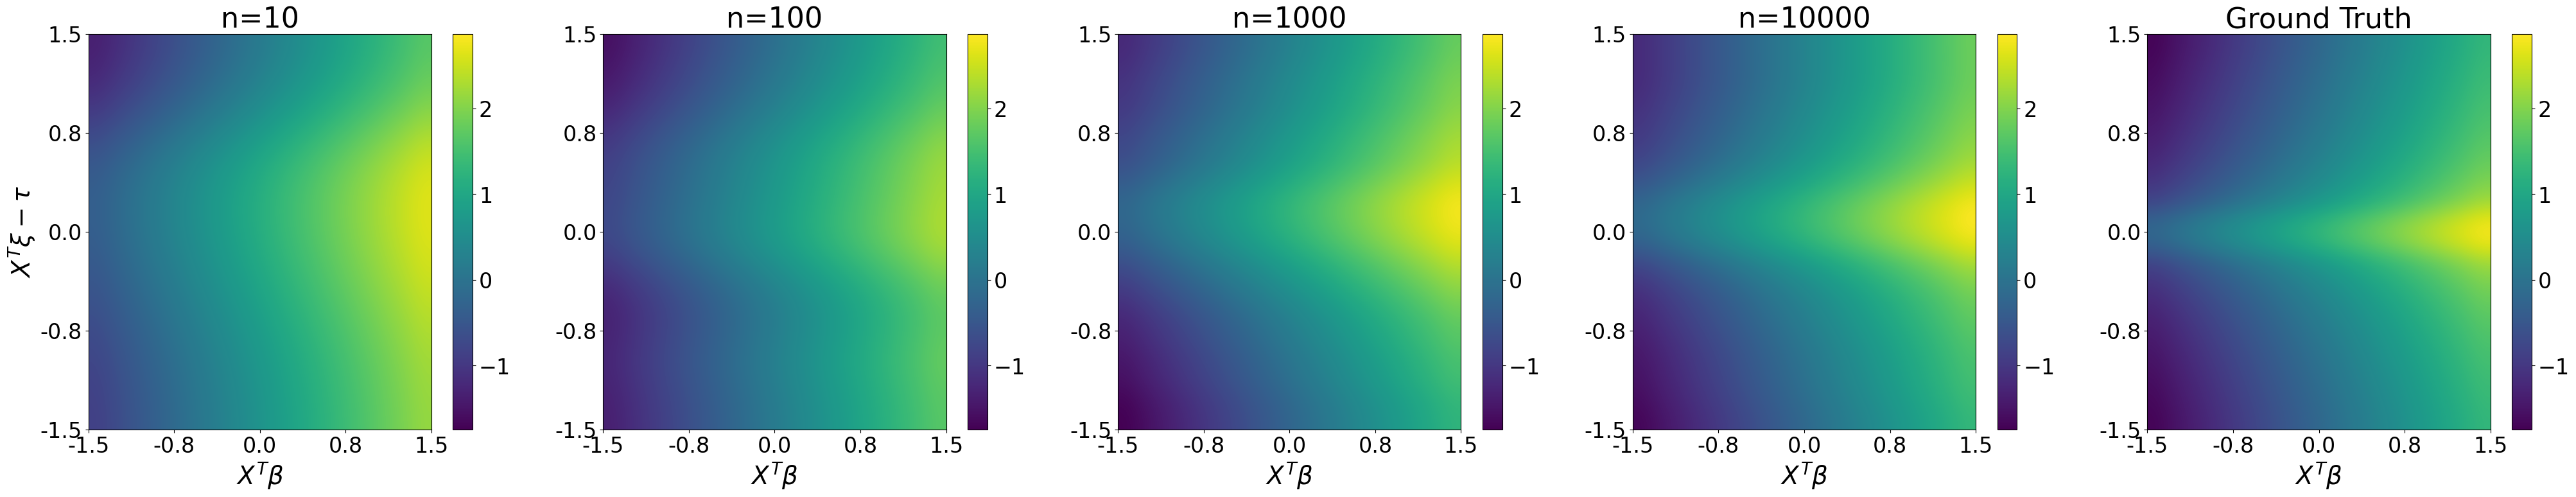

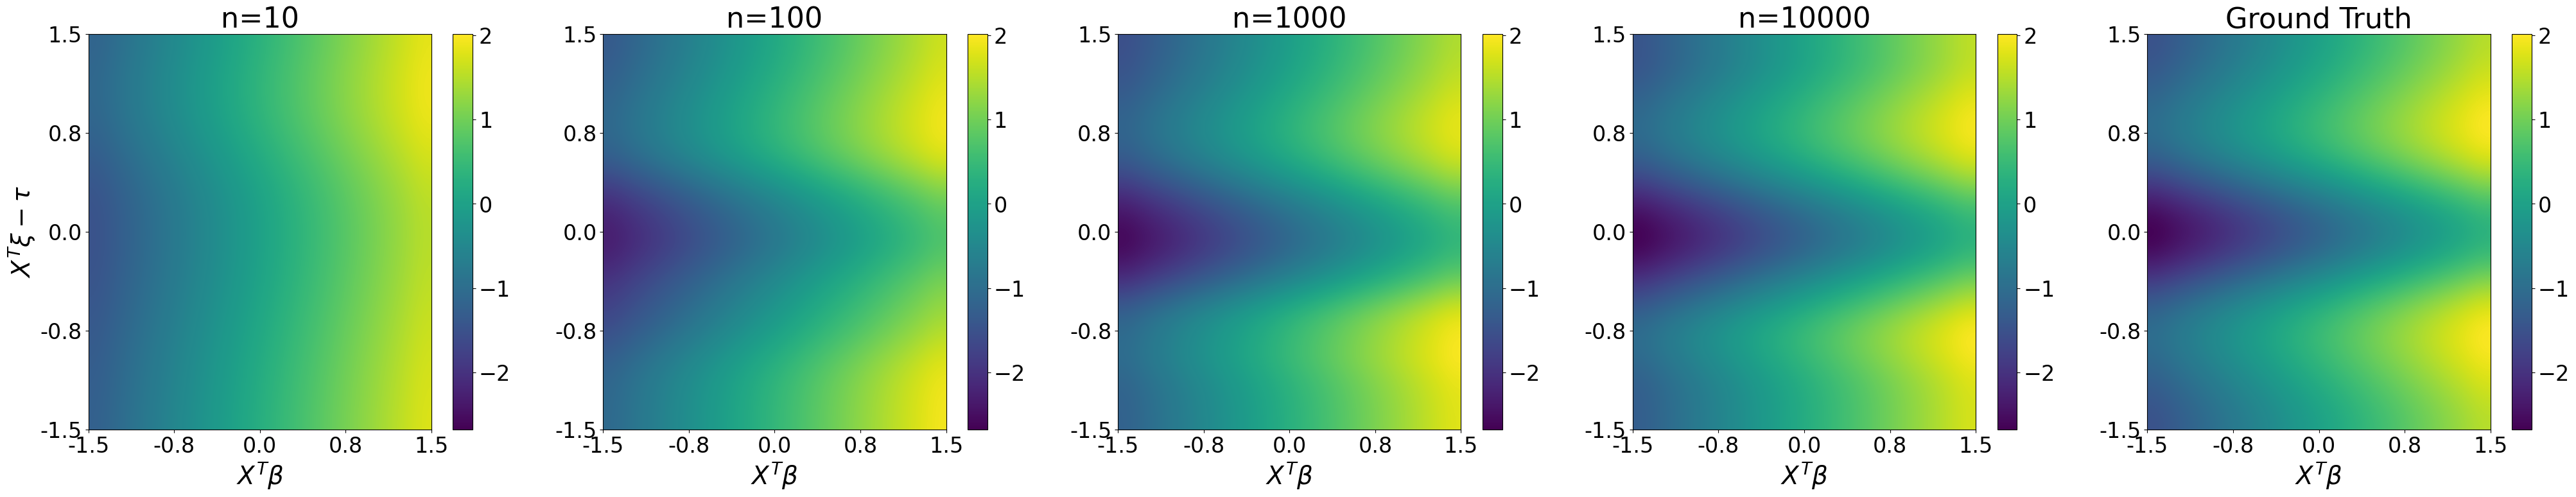

In [13]:
modified_surface_heatmap_plot(heatmaps_1, sample_sizes,'heat_1.png')
modified_surface_heatmap_plot(heatmaps_2, sample_sizes,'heat_2.png')
modified_surface_heatmap_plot(heatmaps_3, sample_sizes, 'heat_3.png')
modified_surface_heatmap_plot(heatmaps_4, sample_sizes, 'heat_4.png')


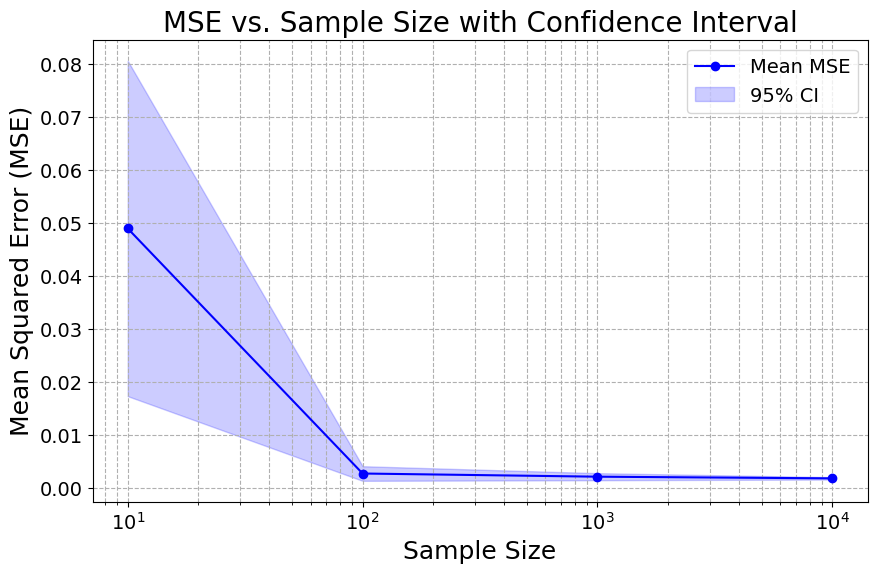

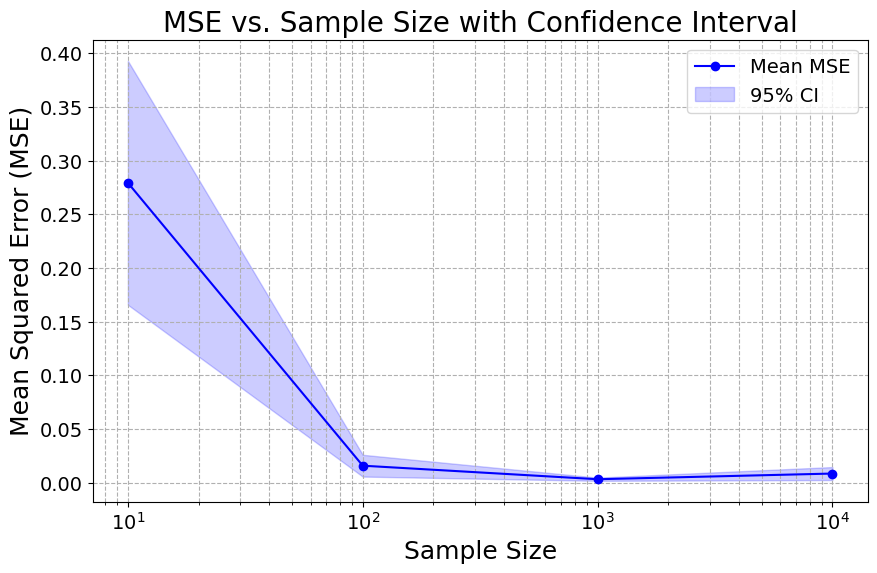

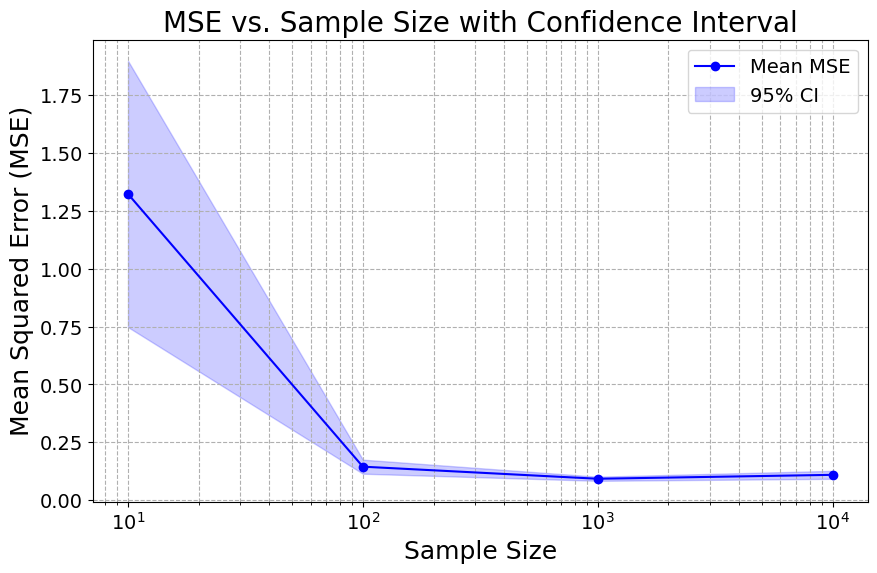

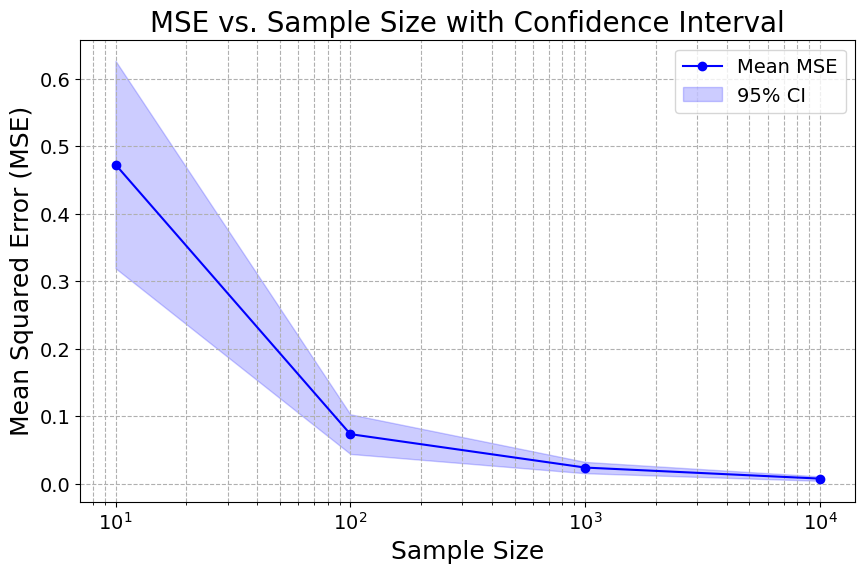

In [14]:
plot_mse_conf(sample_sizes, mse_values_1_means,mse_values_1_cis, "scenario_1.png")
plot_mse_conf(sample_sizes, mse_values_2_means,mse_values_2_cis, "scenario_2.png")
plot_mse_conf(sample_sizes, mse_values_3_means,mse_values_3_cis, "scenario_3.png")
plot_mse_conf(sample_sizes, mse_values_4_means,mse_values_4_cis, "scenario_4.png")
